<a href="https://colab.research.google.com/github/Max-FM/Data_Science_Portfolio/blob/main/google_play_free_app_profitability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Profitable App Profiles for the Google Play Market

The aim of this simple project is to explore the profitability of free Android apps available on the Google Play market. We will be focussing on apps where the main source of income is revenue generated from in-app advertisements, meaning that the number of users will be directly correlated to the profitability of the app. By the end of this project, we hope to have a better understanding of what types of apps are likely to attract users.

## Import required packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
plt.style.use('seaborn-poster')

## Downloading the "Google Play Store Apps" dataset from Kaggle

The dataset we'll be exploring in this project is the "Google Play Store Apps" dataset acquired by Gautham Prakash on June 2021 and available [here](https://www.kaggle.com/gauthamp10/google-playstore-apps) on Kaggle. At the time of writing, this is the most up-to-date dataset available, containing information on 2.3+ million apps available on the Google Play app store.

In [ ]:
# Pointing notebook to Kaggle API key on Google Drive.
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
# If the "Google-Playstore.csv" file does not exist, download from Kaggle and unzip.
if not os.path.exists("Google-Playstore.csv"):
    os.system("kaggle datasets download -d gauthamp10/google-playstore-apps")
    os.system("unzip  '/content/google-playstore-apps.zip' -d '/content'")

## Reading in and initially exploring the dataset



In [ ]:
df = pd.read_csv("Google-Playstore.csv")

In [ ]:
display(
    df.info(),
    df.head()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App Name           object 
 1   App Id             object 
 2   Category           object 
 3   Rating             float64
 4   Rating Count       float64
 5   Installs           object 
 6   Minimum Installs   float64
 7   Maximum Installs   int64  
 8   Free               bool   
 9   Price              float64
 10  Currency           object 
 11  Size               object 
 12  Minimum Android    object 
 13  Developer Id       object 
 14  Developer Website  object 
 15  Developer Email    object 
 16  Released           object 
 17  Last Updated       object 
 18  Content Rating     object 
 19  Privacy Policy     object 
 20  Ad Supported       bool   
 21  In App Purchases   bool   
 22  Editors Choice     bool   
 23  Scraped Time       object 
dtypes: bool(4), float64(4), int64(1), object(15)
memor

None

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,USD,10M,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,USD,2.9M,5.0 and up,Webserveis,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,USD,3.7M,4.0.3 and up,Cabin Crew,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,USD,1.8M,4.0.3 and up,Climate Smart Tech2,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,USD,6.2M,4.1 and up,Rafal Milek-Horodyski,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


We can see that the overwhelming majority (98%) of apps on the Google Play store are available for free.

In [ ]:
df["Free"].value_counts(normalize=True)

True     0.980515
False    0.019485
Name: Free, dtype: float64

We can also see that the split between the for-profit and non-profit apps is fairly even, with a slight preference towards profitable apps.

In [ ]:
df["Not Free"] = df["Free"] == False
df["Profitable"] = df[["Not Free", "Ad Supported", "In App Purchases"]].sum(axis=1) > 0

df["Profitable"].value_counts(normalize=True)

True     0.538013
False    0.461987
Name: Profitable, dtype: float64

Purely looking at the apps available for free, most are for-profit, with the majority of for-profit apps being supported solely through in-app advertisements. Since we don't have access to sales records in this dataset, we therefore can only realistically estimate the profitability of apps funded through in-app advertisements.

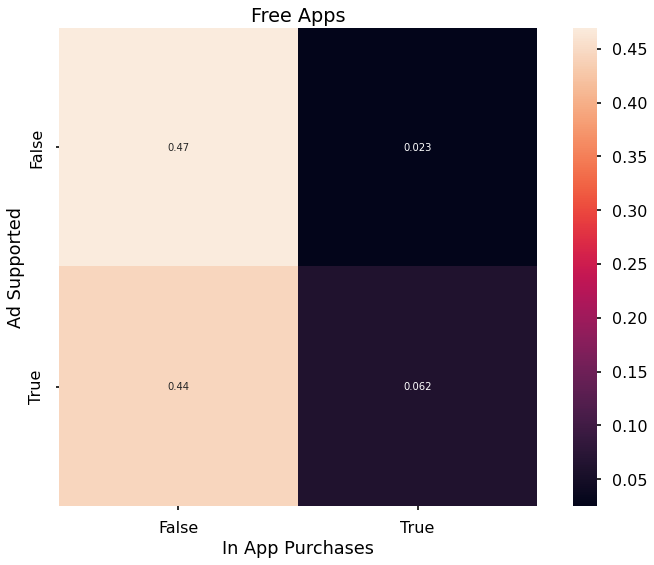

In [ ]:
free_profit = pd.crosstab(
    df.query("Free == True")["Ad Supported"], 
    df.query("Free == True")["In App Purchases"], 
    normalize="all"
)
sns.heatmap(free_profit, annot=True, robust=True, square=True)
plt.title("Free Apps");

## Filtering and cleaning the data

### Filtering down to only free apps that generate purely revenue through in-app advertising

In [ ]:
df = df.query("`Free` == True").query("`Ad Supported` == True").query("`In App Purchases` == False")

### Filtering out apps with no ratings

Over 40% of the apps in our filtered dataset have a rating of 0. Since the lowest rating a user can give is 1 star, apps with a rating of zero have received no reviews and therefore are unlikely to provide any useful information on profitability. It is however a strong indicator of how over-saturated the app market is in 2021.

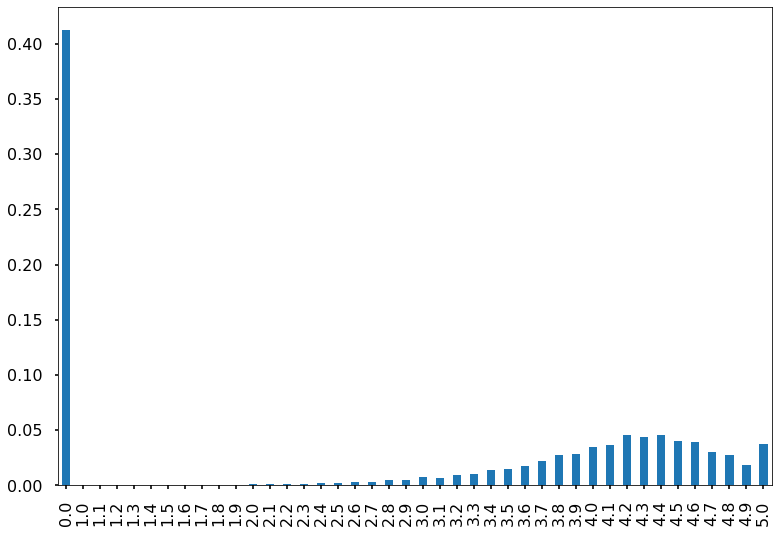

In [ ]:
df["Rating"].value_counts(normalize=True).sort_index().plot.bar();

In [ ]:
df = df.query("`Rating` != 0.0")

### Dropping duplicate rows

In our filtered dataset, there are 1561 rows with duplicate `App Name` and `Developer Id`. We will therefore assume these rows are anomalous duplicate entries that can be dropped from the dataset.

In [ ]:
df[
   df.duplicated(subset=["App Name", "Developer Id"], keep=False)
].sort_values("App Name")

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Not Free,Profitable
407542,10th 12th Board Results 2018,result2018.exam.board.com.myapplication,Education,3.2,37.0,"10,000+",10000.0,46770,True,0.0,USD,2.2M,4.0.3 and up,Mystical info & news,NaN,sagar.enterpises91@gmail.com,"Nov 12, 2017","Nov 12, 2017",Everyone,NaN,True,False,False,2021-06-16 03:12:11,False,True
1623678,10th 12th Board Results 2018,com.mystical.infonews.examresult2018,Education,2.4,9.0,"5,000+",5000.0,7742,True,0.0,USD,2.3M,4.0.3 and up,Mystical info & news,NaN,sagar.enterpises91@gmail.com,"Apr 30, 2018","Apr 26, 2019",Everyone,NaN,True,False,False,2021-06-16 03:07:33,False,True
325232,1xBet Sports Betting x Tips,com.onexbet.xBetsportsbettingxguide,Entertainment,3.8,143.0,"10,000+",10000.0,17856,True,0.0,USD,8.1M,4.4 and up,Adambout,NaN,adamboutchich123@gmail.com,"May 28, 2021","Jun 10, 2021",Everyone,NaN,True,False,False,2021-06-16 01:53:51,False,True
154570,1xBet Sports Betting x Tips,com.onexbetsports.onexBetsportsbettingxguide,Entertainment,3.4,16.0,"1,000+",1000.0,1277,True,0.0,USD,4.8M,4.1 and up,Adambout,NaN,adamboutchich123@gmail.com,"Jun 2, 2021","Jun 02, 2021",Everyone,NaN,True,False,False,2021-06-15 22:51:55,False,True
445252,4 pictures > 1 word,ua.com.ex3m.a4pic_2_de,Word,3.9,8.0,"5,000+",5000.0,5227,True,0.0,USD,21M,4.1 and up,Dron4ik Studio,http://prog.net.ua,dron4ik89@gmail.com,"Jan 7, 2017","Dec 12, 2017",Everyone,http://prog.net.ua/privacy_policy_2.html,True,False,False,2021-06-16 03:45:56,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439249,早上好，下午好，晚安,com.peroinc.chine.moraftnigim,Communication,4.1,37.0,"5,000+",5000.0,5043,True,0.0,USD,4.1M,4.1 and up,Pero Inc,https://devpero.blogspot.com/ads.txt,devpero2020@gmail.com,"May 11, 2020","May 03, 2021",Teen,https://devpero.blogspot.com,True,False,False,2021-06-16 00:26:52,False,True
338518,날씨와 나침반-날씨/나침반/미세먼지/온도/무료,com.ochiri.cskim.weathercom23,Tools,4.8,20.0,"1,000+",1000.0,1109,True,0.0,USD,34M,6.0 and up,eunsoft23,https://eunsoft.netlify.com,eunsoft23@gmail.com,NaN,"May 30, 2021",Everyone,https://eunsoft.netlify.com/privacy-policy,True,False,False,2021-06-16 02:06:51,False,True
1308208,날씨와 나침반-날씨/나침반/미세먼지/온도/무료,com.ochiri.cskim.weathercombrief23,Tools,4.5,15.0,100+,100.0,318,True,0.0,USD,32M,6.0 and up,eunsoft23,https://eunsoft.netlify.com,eunsoft23@gmail.com,NaN,"May 30, 2021",Everyone,https://eunsoft.netlify.com/privacy-policy,True,False,False,2021-06-15 22:17:48,False,True
1344841,👒 👓 College Girls Dress Up,com.college.girls.students,Simulation,4.2,1427.0,"100,000+",100000.0,266309,True,0.0,USD,Varies with device,4.4 and up,Teenage Fashion,NaN,teenagefashion@mail.ru,"Jul 21, 2020","May 24, 2021",Everyone,https://sites.google.com/view/gamesdressup/,True,False,False,2021-06-15 22:50:46,False,True


To ensure we have the best quality data when dropping duplicates, we will therefore be keeping the entry with the highest rating count.

In [ ]:
df = df.sort_values(
    "Rating Count", # Sorting by number of ratings in ascending order.
    ascending=False
).drop_duplicates(
    "App Name" # Keeps the first row by default, therefore keeping the entry with the highest number of ratings.
).sort_index()

### Fixing datatypes

In our filtered dataset, the `App Name` column contains an entry with the `float` datatype. On inspection, we can see that this is a null entry that can be dropped entirely from the dataset. If this row is not dropped, this will cause errors in the next stage of our data cleaning process.

In [ ]:
df["App Name"].map(type).value_counts()

<class 'str'>      554929
<class 'float'>         1
Name: App Name, dtype: int64

In [ ]:
df[
   df["App Name"].map(type) == float
]

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Not Free,Profitable
45686,NaN,se.promedia.NA,News & Magazines,2.4,470.0,"50,000+",50000.0,84097,True,0.0,USD,27M,4.1 and up,Bonnier News Local AB,https://www.na.se/app,kundservice.bnlo@bonniernews.se,"Aug 8, 2011","Dec 21, 2020",Everyone,https://www.na.se/info/mittmedias-personuppgif...,True,False,False,2021-06-15 21:04:54,False,True


In [ ]:
df = df.dropna(subset=["App Name"])

In [ ]:
df["App Name"].map(type).value_counts()

<class 'str'>    554929
Name: App Name, dtype: int64

### Removing non-English language apps

For this study, we will be focussing only on apps aimed at a western, English speaking market. We can potentially filter out a significant majority of these apps by removing apps that contain non-ascii characters in their name. However, this might be an overly aggressive strategy and remove many English language apps that for example, contain emojis in their app name.

In [ ]:
# Showing rows where the `App Name` contains non-ascii characters.
df[
   ~df["App Name"].map(lambda x: x.isascii())
]

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Not Free,Profitable
12,桃園機場捷運時刻表 - 捷運轉乘路線快速查詢(支援台北捷運),com.jieapp.taoyuanmetro,Travel & Local,3.9,118.0,"10,000+",10000.0,37763,True,0.0,USD,7.6M,4.2 and up,Jie App,https://jie-app.herokuapp.com/,jie.myapp@gmail.com,"Apr 3, 2018","Jun 11, 2021",Everyone,http://appsetting.blogspot.tw/2017/02/jie-app....,True,False,False,2021-06-15 20:19:36,False,True
77,경조사 노트 - 치부책,hs.app.event,Finance,4.8,2663.0,"10,000+",10000.0,49190,True,0.0,USD,4.1M,7.0 and up,HS App,NaN,devwlstn@gmail.com,"May 3, 2016","Apr 16, 2021",Everyone,http://blog.naver.com/ringoai0923/220777107423,True,False,False,2021-06-15 20:19:40,False,True
135,Flappy Duck — Angry Bird,com.eveplay.flappybird,Arcade,1.5,8.0,"1,000+",1000.0,1922,True,0.0,USD,3.5M,4.1 and up,EvePlay,NaN,eveplay.online@gmail.com,"Oct 19, 2020","Dec 31, 2020",Everyone,https://github.com/EvePlay/privacypolicy/blob/...,True,False,False,2021-06-15 20:19:43,False,True
158,خواص گیاهان دارویی و میوه ها,kurdsofts.net.khavas_mive,Medical,4.6,4047.0,"100,000+",100000.0,424167,True,0.0,USD,8.1M,4.2 and up,payam ghader kurehpaz,https://7ganj.ir,info@kurdsofts.net,"Oct 12, 2017","Sep 06, 2020",Everyone,http://kurdsofts.net/privacy_policy.html,True,False,False,2021-06-15 20:19:45,False,True
161,O Alcorão em português,com.alcorao.portugues,Books & Reference,4.3,86.0,"10,000+",10000.0,14463,True,0.0,USD,7.2M,4.0 and up,Apps of the future,http://www.larisapps.com,aplicativosreceitas@gmail.com,"May 16, 2019","May 17, 2019",Everyone,https://sites.google.com/view/larisappsprivacy...,True,False,False,2021-06-15 20:19:45,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312873,Canto de Canário,com.appscroy.cantodecanario,Entertainment,4.0,7.0,"1,000+",1000.0,1000,True,0.0,USD,9.4M,4.0.3 and up,Super Aplicativos,http://softcroy.ga/,appscroy@gmail.com,"Mar 19, 2020","Mar 29, 2020",Everyone,NaN,True,False,False,2021-06-16 12:59:15,False,True
2312877,"Библия - ветхий завет,писание",im.dev.bibliavethiy,Books & Reference,4.5,55.0,"10,000+",10000.0,14683,True,0.0,USD,6.1M,2.3 and up,imdev,http://androidcoder.ru,info@androidcoder.ru,"Jul 21, 2015","Oct 10, 2016",Everyone,NaN,True,False,False,2021-06-16 12:59:15,False,True
2312890,Camera Photo Poses – Crazy Poses for Girls Latest,com.mianmuheebrehman.girlsposes.selfiephoto,Entertainment,4.4,19.0,"1,000+",1000.0,2770,True,0.0,USD,7.3M,4.1 and up,MYK Players,NaN,vaidyatwinkle7@gmail.com,"Nov 11, 2018","Aug 24, 2019",Everyone,https://sites.google.com/view/mianmuheebrehman...,True,False,False,2021-06-16 12:59:16,False,True
2312891,Tuyển Tập Đề Thi Tốt Nghiệp THPT Quốc Gia | Ôn...,com.DeThiTHPT.LuyenThiTHPTQuocGia,Education,4.2,57.0,"5,000+",5000.0,6825,True,0.0,USD,28M,5.0 and up,Hùng Ca Đất Việt,NaN,ngothuymui91@gmail.com,"Jun 1, 2020","Apr 23, 2021",Everyone,https://sites.google.com/view/hcdtchinhsach,True,False,False,2021-06-16 12:59:16,False,True


Therefore, it may be more sensible to set a threshold of non-ascii characters. For this study, we will therefore be removing any rows with the `App Name` column containing more than 1 non-ascii character.

In [ ]:
def non_ascii_count(string):
    """Returns the number of non-ascii characters in the input string."""
    ascii_count = len(string.encode("ascii", "ignore"))
    non_ascii_count = len(string) - ascii_count
    
    return non_ascii_count

In [ ]:
# Defining a lambda function to map all entries of the `App Name` column to a column of booleans.
non_ascii_threshold = lambda row: non_ascii_count(row) > 1

Displaying the rows from the data set that match our proposed criteria:

In [ ]:
df[
   df["App Name"].map(non_ascii_threshold)
]

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Not Free,Profitable
12,桃園機場捷運時刻表 - 捷運轉乘路線快速查詢(支援台北捷運),com.jieapp.taoyuanmetro,Travel & Local,3.9,118.0,"10,000+",10000.0,37763,True,0.0,USD,7.6M,4.2 and up,Jie App,https://jie-app.herokuapp.com/,jie.myapp@gmail.com,"Apr 3, 2018","Jun 11, 2021",Everyone,http://appsetting.blogspot.tw/2017/02/jie-app....,True,False,False,2021-06-15 20:19:36,False,True
77,경조사 노트 - 치부책,hs.app.event,Finance,4.8,2663.0,"10,000+",10000.0,49190,True,0.0,USD,4.1M,7.0 and up,HS App,NaN,devwlstn@gmail.com,"May 3, 2016","Apr 16, 2021",Everyone,http://blog.naver.com/ringoai0923/220777107423,True,False,False,2021-06-15 20:19:40,False,True
158,خواص گیاهان دارویی و میوه ها,kurdsofts.net.khavas_mive,Medical,4.6,4047.0,"100,000+",100000.0,424167,True,0.0,USD,8.1M,4.2 and up,payam ghader kurehpaz,https://7ganj.ir,info@kurdsofts.net,"Oct 12, 2017","Sep 06, 2020",Everyone,http://kurdsofts.net/privacy_policy.html,True,False,False,2021-06-15 20:19:45,False,True
161,O Alcorão em português,com.alcorao.portugues,Books & Reference,4.3,86.0,"10,000+",10000.0,14463,True,0.0,USD,7.2M,4.0 and up,Apps of the future,http://www.larisapps.com,aplicativosreceitas@gmail.com,"May 16, 2019","May 17, 2019",Everyone,https://sites.google.com/view/larisappsprivacy...,True,False,False,2021-06-15 20:19:45,False,True
231,Bệnh viện Quận 2 - Đặt khám online,youmed.bv.bvq2,Medical,4.6,16.0,500+,500.0,872,True,0.0,USD,23M,4.1 and up,YouMed Vietnam,https://youmed.vn/,hostmaster@youmed.vn,"Dec 6, 2019","Jun 15, 2021",Everyone,https://www.termsfeed.com/privacy-policy/81038...,True,False,False,2021-06-15 20:19:49,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2312845,Морской бой,com.avsappdevelopment.seabattleRU,Arcade,3.4,28.0,"10,000+",10000.0,14422,True,0.0,USD,21M,4.4 and up,AVS App Development,https://u941d7ac3.app-ads-txt.com,shatova_app@mail.ru,"Jul 17, 2019","Dec 22, 2020",Everyone,https://atasja.github.io/SeaBattle_RU_PrivacyP...,True,False,False,2021-06-16 12:59:14,False,True
2312868,Домашняя выпечка с фото,com.domashnyayavypechkasfoto7,Food & Drink,4.2,12.0,"1,000+",1000.0,3649,True,0.0,USD,3.0M,4.0.3 and up,Media Catalog,NaN,olgaermolova2019@gmail.com,"May 22, 2020","May 22, 2020",Everyone,NaN,True,False,False,2021-06-16 12:59:15,False,True
2312877,"Библия - ветхий завет,писание",im.dev.bibliavethiy,Books & Reference,4.5,55.0,"10,000+",10000.0,14683,True,0.0,USD,6.1M,2.3 and up,imdev,http://androidcoder.ru,info@androidcoder.ru,"Jul 21, 2015","Oct 10, 2016",Everyone,NaN,True,False,False,2021-06-16 12:59:15,False,True
2312891,Tuyển Tập Đề Thi Tốt Nghiệp THPT Quốc Gia | Ôn...,com.DeThiTHPT.LuyenThiTHPTQuocGia,Education,4.2,57.0,"5,000+",5000.0,6825,True,0.0,USD,28M,5.0 and up,Hùng Ca Đất Việt,NaN,ngothuymui91@gmail.com,"Jun 1, 2020","Apr 23, 2021",Everyone,https://sites.google.com/view/hcdtchinhsach,True,False,False,2021-06-16 12:59:16,False,True


Filtering out rows meeting the non-ascii criteria:

In [ ]:
df = df[
        ~df["App Name"].map(non_ascii_threshold)
]

We can see below our filter has done an okay job in removing the majority of non-English language apps. Unfortunately, a significant number of non-English language apps remain and there's potentially a significant number of English apps that got removed. Future work could include devising a more robust filter for this particular section, maybe involving some use of natural language processing. However, that's a potential project in its own right and currently beyond the scope of this study.

In [ ]:
df[
   ~df["App Name"].map(lambda x: x.isascii())
].sample(10)

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Minimum Android,Developer Id,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Not Free,Profitable
259650,UGC Direct - Films et Cinéma,air.ugc.fr.ugcdirect,Entertainment,4.3,6384.0,"500,000+",500000.0,701384,True,0.0,USD,23M,4.1 and up,UGC,https://www.ugc.fr/aideEtContact.html,serviceclient@ugc.fr,NaN,"May 10, 2021",Teen,https://www.ugc.fr/conditions-MonCompte.html,True,False,False,2021-06-16 00:46:57,False,True
631351,"Color Disk 🔄 Rotate, Switch, Match Ball",com.companyname.ColorfulGame,Casual,4.9,16.0,500+,500.0,767,True,0.0,USD,31M,4.0 and up,Cosmos Games Dev.,NaN,cosmosgamesmain@gmail.com,"Jul 25, 2018","Aug 18, 2018",Everyone,NaN,True,False,False,2021-06-16 06:33:55,False,True
630796,Periódicos Argentinos,com.lsperiodicos.argentinos,News & Magazines,4.5,149.0,"1,000+",1000.0,1863,True,0.0,USD,3.5M,4.1 and up,Ludel Studio,https://ludelstudio.blogspot.com/,Ludeldeveloper@gmail.com,"Dec 12, 2020","Jun 10, 2021",Everyone,https://ludelstudio.blogspot.com/p/terminos-y-...,True,False,False,2021-06-16 06:33:14,False,True
1336525,FLEX - FILMES & SÉRIES - LEGENDADO,com.PROJETOSPARENTE.FLEX,Entertainment,1.9,1207.0,"100,000+",100000.0,296716,True,0.0,USD,Varies with device,4.0.3 and up,PROJETOS PARENTE,http://projetosparente.com.br/plataformaflix/,flex@projetosparente.com.br,"Jun 1, 2019","Jun 23, 2019",Everyone,http://www.projetosparente.com.br/plataformafl...,True,False,False,2021-06-15 22:43:02,False,True
725850,Rádio USP FM 93.7 SP,com.kradioapp.radiouspfm937sp,Music & Audio,2.8,5.0,500+,500.0,921,True,0.0,USD,4.6M,4.0.3 and up,KRADIOAPP,NaN,carlosehp@gmail.com,"Feb 23, 2019","Feb 24, 2019",Teen,https://www.facebook.com/notes/best-apps/priva...,True,False,False,2021-06-16 08:02:25,False,True
1925581,Repères Histoire Brevet,com.sertook.rhb,Education,4.5,1601.0,"100,000+",100000.0,151980,True,0.0,USD,5.4M,2.3 and up,Sertook,http://www.sertook.com,contact@sertook.com,"Apr 30, 2013","Mar 07, 2015",Everyone,https://rhb.neocities.org/privacy_policy.html,True,False,False,2021-06-16 07:21:05,False,True
116433,PrankBros Soundboard für Fans,me.clemax.kotlinsoundboard,Entertainment,3.6,61.0,"10,000+",10000.0,11326,True,0.0,USD,6.3M,5.0 and up,Milops,NaN,milopsapps@gmail.com,"Feb 10, 2019","Feb 26, 2019",Teen,https://pastebin.com/vy8R6MG0,True,False,False,2021-06-15 22:14:16,False,True
34798,Gîtes en France - Gite & BnB,com.geotys.gitesenfrance,Travel & Local,2.2,58.0,"10,000+",10000.0,26494,True,0.0,USD,3.0M,2.3.3 and up,Geotys,http://www.gites-en-france.net,cyrilwolski@gmail.com,"Jun 18, 2013","Jul 24, 2014",Everyone,http://www.gites-en-france.net,True,False,False,2021-06-15 20:54:11,False,True
594844,Spot the difference 500 levels – Brain Puzzle,com.TanApps.FindTheDifferences500_7,Puzzle,4.7,1448.0,"50,000+",50000.0,92922,True,0.0,USD,61M,4.1 and up,TANapps,http://tanappsgames.net/,tanacapps@gmail.com,"Apr 28, 2020","Feb 13, 2021",Everyone,http://tanappsgames.net/500_7/Privacy%20Policy...,True,False,False,2021-06-16 06:00:37,False,True
2306888,Felsefe Ders Notları,com.flsf.felsefe,Education,4.1,394.0,"50,000+",50000.0,74649,True,0.0,USD,1.9M,4.0 and up,Barasfe Apps,https://sanalderslik.net/,aslan.yergok@gmail.com,"Dec 16, 2013","Jan 26, 2020",Everyone,https://sites.google.com/view/yergok-com/priva...,True,False,False,2021-06-16 12:53:57,False,True


### Displaying the filtered/cleaned data set information

Using the filtering/cleaning techniques detailed above, we have reduced our data set from around 2.3 million to approximately 500,000 apps of interest to our study.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478801 entries, 1 to 2312938
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   App Name           478801 non-null  object 
 1   App Id             478801 non-null  object 
 2   Category           478801 non-null  object 
 3   Rating             474035 non-null  float64
 4   Rating Count       474035 non-null  float64
 5   Installs           478801 non-null  object 
 6   Minimum Installs   478801 non-null  float64
 7   Maximum Installs   478801 non-null  int64  
 8   Free               478801 non-null  bool   
 9   Price              478801 non-null  float64
 10  Currency           478801 non-null  object 
 11  Size               478758 non-null  object 
 12  Minimum Android    478194 non-null  object 
 13  Developer Id       478796 non-null  object 
 14  Developer Website  283643 non-null  object 
 15  Developer Email    478800 non-null  object 
 16  R

## Exploring the number of free, for-profit apps by category

By plotting the count of categories in our filtered dataset, we can get a general idea of the distribution of free apps that generate revenue by in-app advertisements. The three most commonly made free, for-profit apps are in the "Entertainment", "Music & Audio" and "Education" categories. Whilst this isn't an indicator of the success of a particular category, it instead gives us an indicator of which categories are potentially over-saturated.

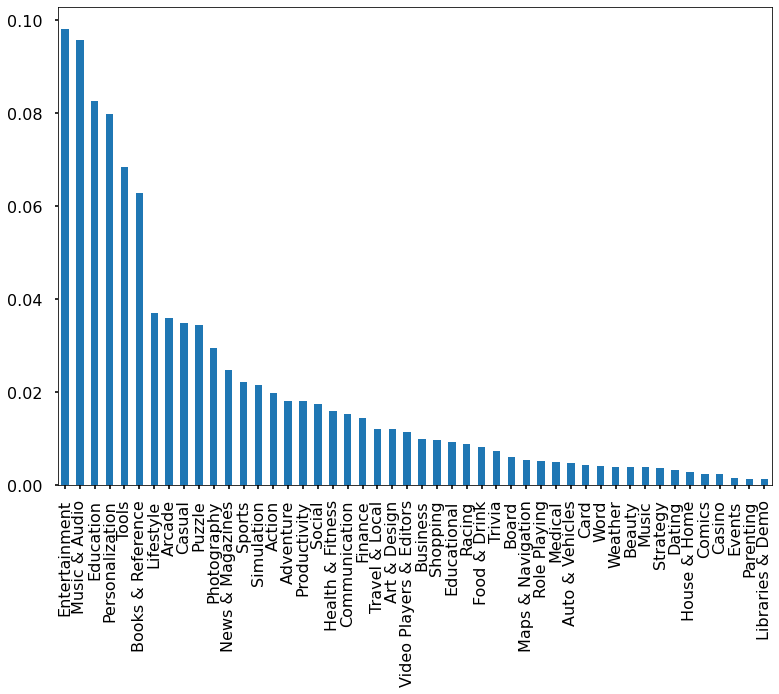

In [ ]:
df["Category"].value_counts(normalize=True).plot.bar();

## Determining the popularity of each app category

In order to analyse the "popularity" of each app category, we can create a series of boxplots displaying how the number of installs, rating counts and rating scores are distributed across each category. We can then order the boxplots in descending order by the median value in each category to help illustrate which categories are more "popular". We are interested in the median over the mean for this analysis, as we wish to explore the general popularity of each category without being biased by the extreme outliers in our dataset. For example, a small number of very popular apps in one category may make the category as a whole seem more popular than it actually is.

### Number of installs

Below is a series of boxplots showing the distribution of `Maximum Installs` across each category. The major caveat with this column is that it's likely only an estimate, with the only other column indicating the number of installations being `Minimum Installs`, which groups the data into very rough categories, making it unlikely to provide very useful insights. Assuming the `Maximum Installs` estimates are accurate, we can see that the "Simulation" category has the highest median number of installs and by a significant margin when compared to the other categories.

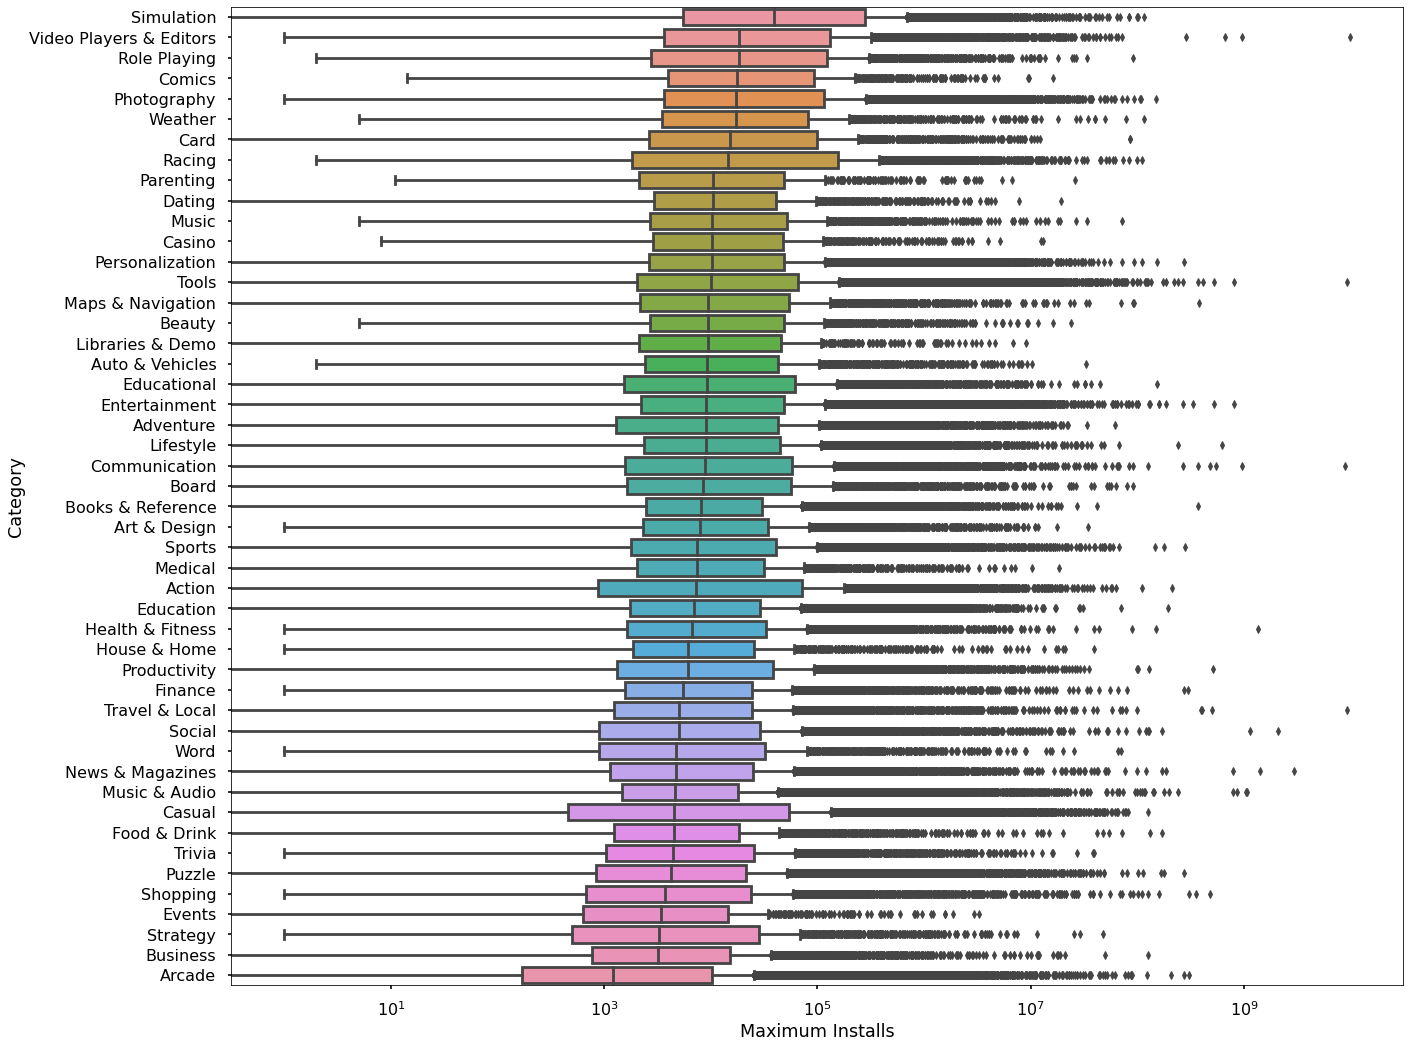

In [ ]:
fig, ax = plt.subplots(figsize=(21,18))
ax.set(xscale="log")

median_order = df.groupby("Category")["Maximum Installs"].median().sort_values(ascending=False).index # Ordering the box plots by the median number of installs of each category (in descending order).
sns.boxplot(y="Category", x="Maximum Installs", order=median_order, ax=ax, data=df);

Numerically breaking down the statistics for the number of installs across the ten most popular categoies (using the median). We can see that the "Simulation" category has almost double the amount of median installs compared to the "Video Players & Editors" category, which ranks number two on our list. However, interestingly we can see how skewed these distributions are by observing the large differences between the median (50%) and mean columns, showing that the market in most of these categories is dominated by a small number of extremely popular apps. Therefore it’s clear that pretty much all of these app categories are oversaturated with unpopular apps, proving that this is an extremely competitive market, no matter the genre of the app.

In [ ]:
df.groupby("Category")["Maximum Installs"].describe().sort_values("50%", ascending=False)[:10]

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Simulation,10249.0,5.494459e+05,3.067127e+06,0.0,5466.00,39255.0,278662.00,1.156898e+08
Video Players & Editors,5468.0,2.739538e+06,1.330851e+08,1.0,3666.25,18501.0,130179.75,9.766231e+09
Role Playing,2467.0,3.699432e+05,2.386937e+06,2.0,2734.00,18175.0,123813.00,9.131371e+07
Comics,1119.0,1.912041e+05,7.674725e+05,14.0,3991.50,17784.0,92341.50,1.611902e+07
Photography,14094.0,4.876076e+05,3.097926e+06,1.0,3672.25,17327.5,116304.25,1.507795e+08
Weather,1887.0,4.443761e+05,3.935726e+06,5.0,3501.50,17182.0,81254.00,1.144004e+08
Card,2041.0,3.501974e+05,2.857098e+06,0.0,2646.00,15240.0,98487.00,8.612385e+07
Racing,4237.0,6.595651e+05,3.999787e+06,2.0,1835.00,14496.0,154387.00,1.103037e+08
Parenting,622.0,1.905340e+05,1.160477e+06,11.0,2128.00,10577.0,48898.25,2.590761e+07


### Number of Ratings

We can also look at the distribution of the number of ratings within each category, which is not based on any estimates and can potentially enhance our picture of what the most popular categories are. Once again, the "Simulations" category has the highest median number of ratings, indicating that not only is this is potentially a very popular category, it also has a more engaged userbase than the other categories.

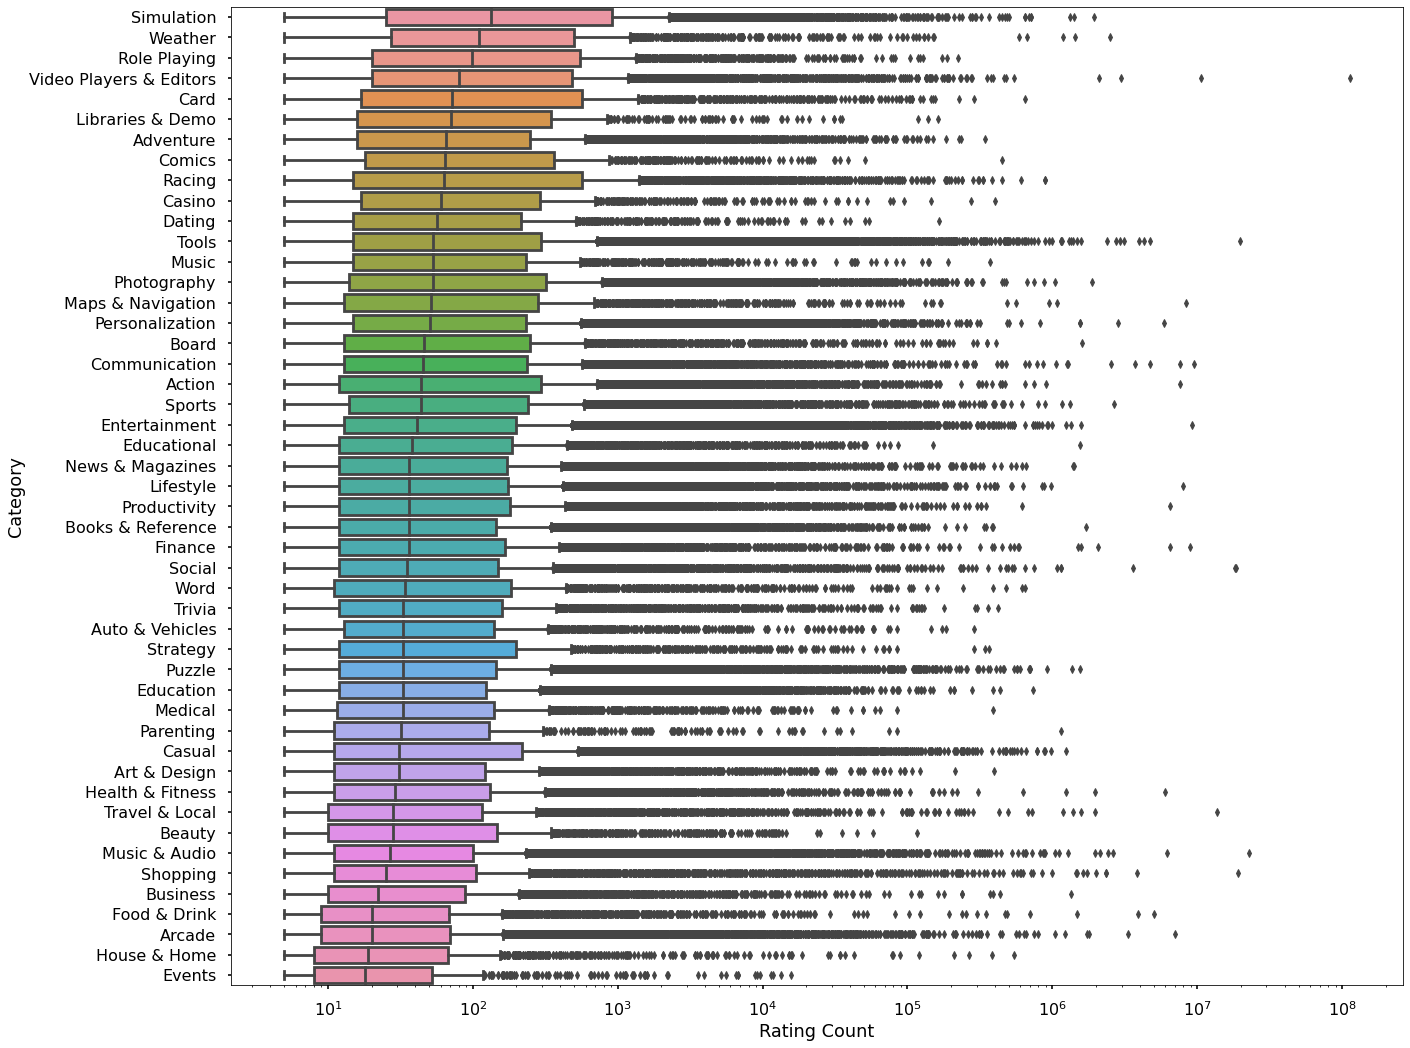

In [ ]:
fig, ax = plt.subplots(figsize=(21,18))
ax.set(xscale="log")
order = df.groupby("Category")["Rating Count"].median().sort_values(ascending=False).index # Ordering the box plots by the median rating counts of each category in descending order.
sns.boxplot(y="Category", x="Rating Count", order=order, ax=ax, data=df);

Once again, numerically breaking down the statistics for the number of ratings, we see that the "Simulation" category has no significant lead on the median number of ratings. As before, the large differences between the median and mean are very apparent, enhancing the conclusions we made previously.


In [ ]:
df.groupby("Category")["Rating Count"].describe().sort_values("50%", ascending=False)[:10]

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Simulation,9992.0,3608.747298,3.546511e+04,5.0,25.00,134.0,919.25,1936780.0
Weather,1850.0,5437.627027,7.594606e+04,5.0,27.25,110.0,503.00,2498195.0
Role Playing,2338.0,1807.704021,9.945020e+03,5.0,20.00,99.0,547.50,222643.0
Video Players & Editors,5444.0,26987.228508,1.531609e+06,5.0,20.00,80.0,486.00,112440547.0
Card,2001.0,3165.938531,2.024870e+04,5.0,17.00,72.0,563.00,648012.0
Libraries & Demo,597.0,1637.584590,1.050454e+04,5.0,16.00,71.0,347.00,161834.0
Adventure,8540.0,1077.566745,7.996999e+03,5.0,16.00,65.0,249.00,342481.0
Comics,1099.0,1240.338490,1.393588e+04,5.0,18.00,64.0,365.00,449977.0
Racing,4144.0,4067.663369,2.944072e+04,5.0,15.00,63.0,569.25,895825.0


### Average Rating
 
Finally, we can look at the median rating within each category. We can now see that the "Simulation" category is actually the second lowest-rated category, despite having the highest median number of installations. This would explain the higher number of ratings, as people more typically write negative reviews than positive ones. This is also true for a lot of other categories with a high median number of downloads and ratings, for example, the "Video Players & Editors", "Role Playing" and "Card" categories. This indicates that these popular categories are saturated with low-quality apps, potentially indicating a market for higher-quality apps in these categories.

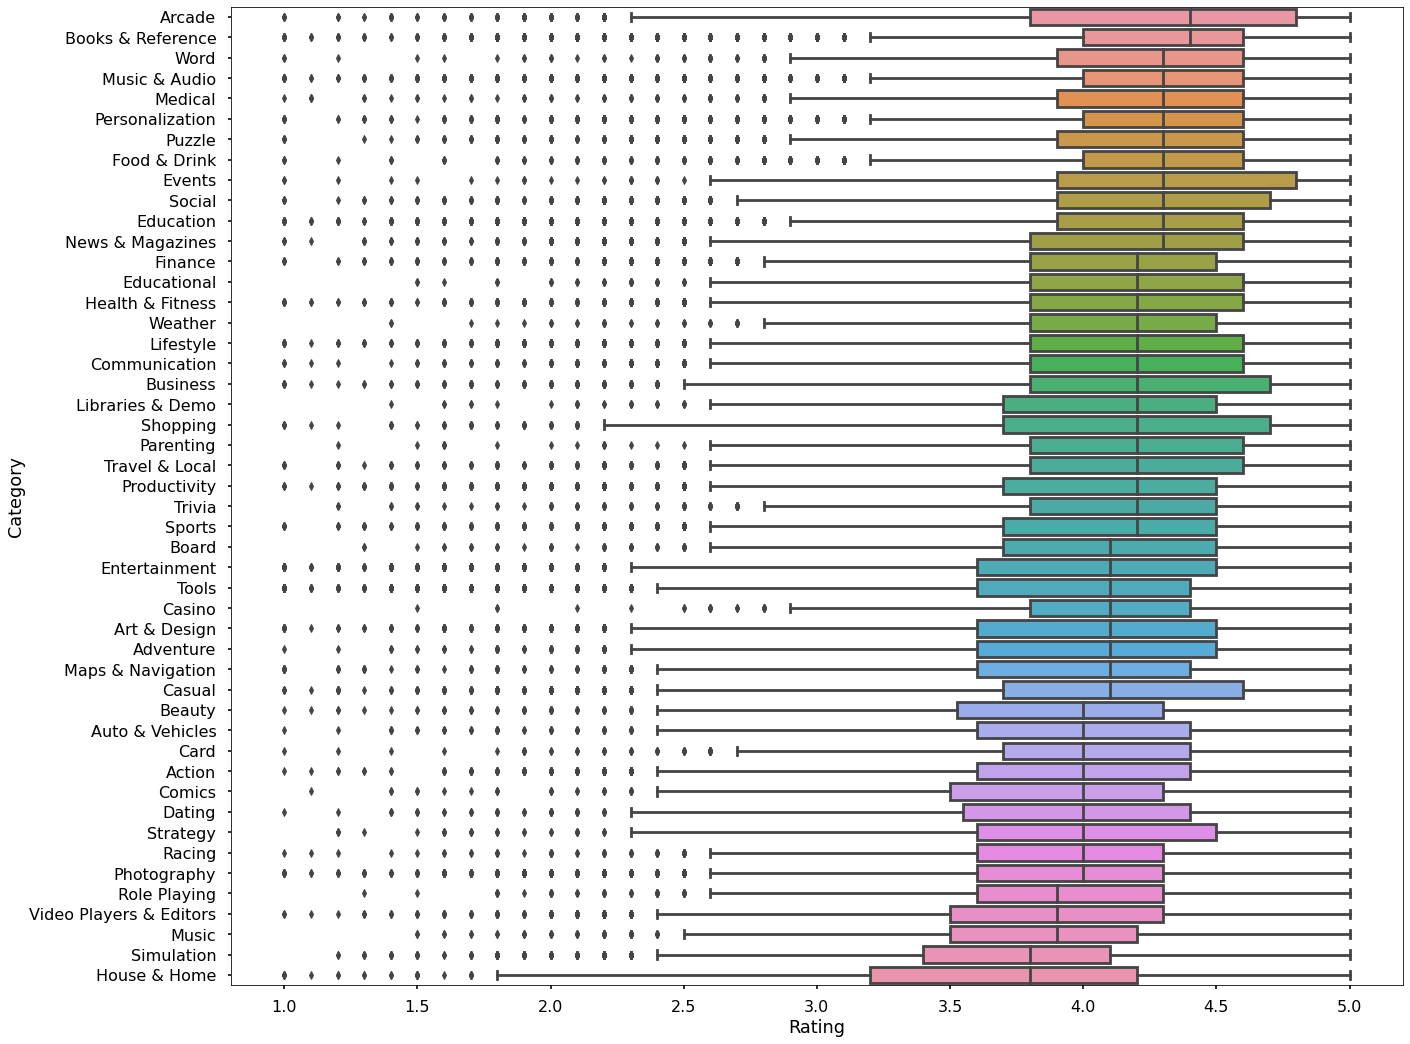

In [ ]:
fig, ax = plt.subplots(figsize=(21,18))
order = df.groupby("Category")["Rating"].median().sort_values(ascending=False).index # Ordering the box plots by the median rating score of each category in descending order.
sns.boxplot(y="Category", x="Rating", order=order, ax=ax, data=df);

We can quickly check to see if the high popularity/low review score is a trend across the whole dataset by checking the value of the Pearson correlation coefficient between the two columns. However, it becomes quickly apparent that these two columns share effectively no association.

In [ ]:
df.corr().loc["Rating", "Maximum Installs"]

-0.00020928039379770116

## Conclusions

This notebook was designed to provide a surface-level overview of the popularity of categories populated by free apps supported by in-app advertisements in the Google Play market. After cleaning and filtering the dataset, we assessed the popularity of each category by exploring the distributions of installations, rating counts and rating scores across each category. In conclusion, it is clear that the market is saturated with low popularity apps and that the market in each category is essentially dominated by a small number of very popular apps. This study has shown how competitive the Android app market is and that no clear conclusions can be drawn as to whether the category is a major determinant of the success of an app in the market. We however did identify the “Simulation” category to be potentially interesting, with both the highest median number of installs and ratings, but with the second-lowest median review score. This indicates a potential market for a free ad-supported app in this category, provided it is an app of considerable quality that engages with its userbase to constantly improve based on the provided feedback. However, it is very important to note that the variance in the number of installations and ratings across each category means these conclusions could realistically apply to any category.

### Future Work

As future work, we could extend these analyses to the iOS App Store dataset to gain a more complete picture of the app market as a whole. We could improve our filtering of non-English language applications, potentially incorporating machine learning/natural language processing algorithms. We could also further our analyses by looking at the popularity of each category over time, as currently, we are only looking at the dataset across the full time-series and apps with a large overall number of installs might not be so popular today. We could also break down our dataset even further and perform more advanced statistical analyses to better understand which free apps are more likely to profit. Finally, we could look into obtaining additional datasets and merging them to our current dataset to further enrich our understanding, including details such as profit margins, user metrics, etc. across each app. However, it's likely that obtaining this additional data will be a difficult and complex task.